In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import h5py
import itertools 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from  keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential


Using TensorFlow backend.


In [3]:
D=[]
check=[]
label = []
for folder in ["32_7ms/ok","32_7ms/nok"]:
    i = 0
    for file in os.listdir(folder):
        if(i>400):
            continue
        if(".npy" in file):
            spectogram = np.load(folder+"/"+file)
            if spectogram.shape != (96, 32): continue
            D.append((spectogram, folder))
            label.append(folder)
            check.append(spectogram) #może tu normalizować
            i+=1
print(len(D),len(D[0]),"done")

688 2 done


In [4]:
def normalization(data,x_max,x_min):
    diff = x_max-x_min
    for rows in range(0,len(data)):
        for cols in range(0,len(data[0])):
            data[rows][cols] = (data[rows][cols]-x_min)/diff 
    return data

In [5]:
dataset_min = np.amin(check)
dataset_max = np.amax(check) #jak teraz znormalizuje to jak potem to zrobić?
print(dataset_min,dataset_max)
dataset_normalized = []
for data in D:
    dataset_normalized.append([normalization(data[0],dataset_max,dataset_min),data[1]])

3.2945329903332993e-09 0.0006509951221093927


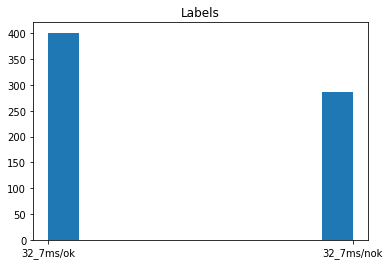

In [6]:
plt.hist(label)  # arguments are passed to np.histogram
plt.title("Labels")
plt.show()

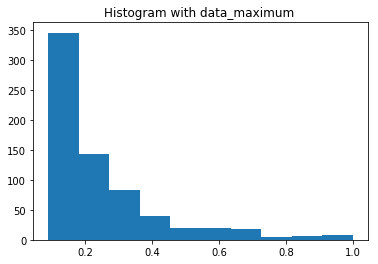

In [7]:
plt.hist([np.amax(data_x[0]) for data_x in dataset_normalized])  # arguments are passed to np.histogram
plt.title("Histogram with data_maximum ")
plt.show()

In [9]:
dataset_array = keras.utils.normalize(check,axis=-1,order=2)
dataset = dataset_normalized

print(len(D))
print(len(D[0]))
print(len(D[0][0]))
print(len(D[0][0][0]))
random.shuffle(dataset)

train = dataset[:600]
test = dataset[600:]

x_train, y_train = zip(*train)
x_test, y_test = zip(*test)

# Reshape for CNN input
fft_size = 96
cols = 32
x_train = np.array([x.reshape( (fft_size, cols, 1) ) for x in x_train])
x_test = np.array([x.reshape( (fft_size, cols, 1) ) for x in x_test])

# One-Hot encoding for classes
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
print(y_test)

688
2
96
32
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1
 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0
 0 0 0 1 0 1 0 1 0 1 1 1 1 1]


In [10]:
Tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', write_images=True)
filepath="weights-improvement.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor="acc", verbose=1, save_best_only=True)
callbacks_list = [checkpoint,Tensor_board]

In [ ]:
#architekrura 128x32
model = Sequential()
input_shape=(128, 32, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

In [12]:
#architektura 96x32
model = Sequential()
input_shape=(fft_size, cols, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 92, 28, 24)        624       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 14, 24)        0         
_________________________________________________________________
activation_3 (Activation)    (None, 46, 14, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 10, 48)        28848     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 5, 48)         0         
_________________________________________________________________
activation_4 (Activation)    (None, 10, 5, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 1, 48)          57648     
__________

In [10]:
model.load_weights("weights-improvement_100model.hdf5")

In [14]:
optimazerAdam = keras.optimizers.Adam(lr=0.0001, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['acc'])#accuracy

history = model.fit(x_train, y_train,
          epochs=50,
          batch_size=128,
          callbacks = callbacks_list)

score = model.evaluate(x_test, y_test, batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
## tensorboard --logdir C:\Users\Jakub\praca_inzynierska\Scissors_falling\logs --port=8080

Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 0.6931 - acc: 0.5050

Epoch 00001: acc improved from -inf to 0.50500, saving model to weights-improvement.hdf5
Epoch 2/50
600/600 [==============================] - 3s 6ms/step - loss: 0.6892 - acc: 0.5733

Epoch 00002: acc improved from 0.50500 to 0.57333, saving model to weights-improvement.hdf5
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 0.6869 - acc: 0.5667

Epoch 00003: acc did not improve from 0.57333
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 0.6844 - acc: 0.5800

Epoch 00004: acc improved from 0.57333 to 0.58000, saving model to weights-improvement.hdf5
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 0.6806 - acc: 0.5883

Epoch 00005: acc improved from 0.58000 to 0.58833, saving model to weights-improvement.hdf5
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 0.6765 - acc: 0.5850

Epoch 00006: 

600/600 [==============================] - 4s 6ms/step - loss: 0.1254 - acc: 0.9667

Epoch 00049: acc improved from 0.95333 to 0.96667, saving model to weights-improvement.hdf5
Epoch 50/50
600/600 [==============================] - 4s 6ms/step - loss: 0.1174 - acc: 0.9583

Epoch 00050: acc did not improve from 0.96667
88/88 [==============================] - 0s 3ms/step
Test loss: 0.1347023844718933
Test accuracy: 0.9431818127632141


In [ ]:
print(history.history)

In [ ]:
model.save_weights("model_128_7ms.h5")
print("Saved model to disk")

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

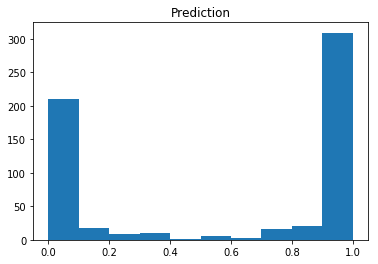

[[246   9]
 [  2 343]]
Confusion matrix, without normalization
Recall/Czułość: 0.992 Precision/Precyzja: 0.965 F-Score: 0.978


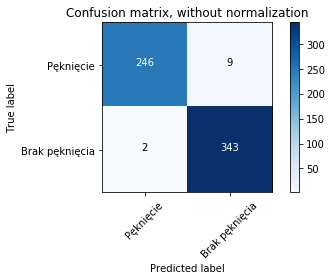

In [17]:
prediction = []
prediction_label =[]
prediction_predicted = []
for i in range(0,len(y_train)):
    prediction.append(model.predict(x_train[i].reshape(1,fft_size,cols,1))[0][0])
    prediction_label.append(y_train[i])
    prediction_predicted.append(round(prediction[i]))
    
        
#print(prediction,prediction_label)
#for check_item in dataset_normalized:
#   prediction.append(model.predict(check_item[0].reshape(1,128,128,1))[0][0])
#   prediction_label.append(check_item[1])
#    if(prediction[-1]>0.5):
#       prediction_predicted.append("128_7ms/ok")
#    else:
#        prediction_predicted.append("128_7ms/nok")
        
plt.hist(prediction)  # arguments are passed to np.histogram
plt.title("Prediction")
plt.show()
matrix = confusion_matrix(y_pred=prediction_predicted,y_true=prediction_label)
print(matrix)
plt.figure()
plot_confusion_matrix(matrix, classes=["Pęknięcie",'Brak pęknięcia'],
                      title='Confusion matrix, without normalization')
recall = (matrix[0][0])/(matrix[0][0]+matrix[1][0])
precision = (matrix[0][0])/(matrix[0][0]+matrix[0][1])
score = 2/((1/recall) + (1/precision))
print("Recall/Czułość: {0:0.3f}".format(recall),"Precision/Precyzja: {0:0.3f}".format(precision),"F-Score: {0:0.3f}".format(score))